In [1]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 167.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 176.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 188.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 73.

In [2]:
#!pip install librosa soundfile ffmpeg-python

In [3]:
import json
import os
from datasets import Dataset, Audio
import torch

In [ ]:
from huggingface_hub import login
from dotenv import load_dotenv

# Charger les variables depuis le fichier .env
load_dotenv()

hf_token = os.environ.get("HF_TOKEN")
# Login to the Hugging Face Hub
login(token=hf_token)

In [ ]:
path = "./Collecte_Audio_Challence6_AI_Pionieers_Isheero"

In [ ]:
# Charger le dictionnaire dico_corpus.json
with open('dico_corpus.json', 'r') as f:
  dico_corpus = json.load(f)

### Construction d’une liste d’enregistrements

In [7]:
records = []
for idx, meta in dico_corpus.items():
    folder = f"{path}/{meta['identifiant']}"
    # parcourir tous les fichiers .wav (ou .mp3) dans le dossier
    for fname in os.listdir(folder):
        if fname.endswith(('.wav', '.flac', '.mp3', '.webm')):
            records.append({
                "audio": os.path.join(folder, fname),
                "text": meta['contenu']
            })


### Création du Dataset

In [8]:
# Créer le dataset à partir de la liste
ds = Dataset.from_list(records)

# Indiquer que la colonne "audio" contient des fichiers audio
#ds = ds.cast_column("audio", Audio(sampling_rate=16_000))

In [9]:
ds

Dataset({
    features: ['audio', 'text'],
    num_rows: 106
})

### Speech Processing

In [10]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(
    "openai/whisper-tiny",
    language="fr",       # si vos données sont en français
    task="transcribe"    # transcription seule
)
# WhisperProcessor = WhisperFeatureExtractor + WhisperTokenizer
# En effet, l'Extractor transforme les audio en log mel(spectogramme) et le Tokenizer pour tokenizer les labels

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

In [11]:
import torchaudio

def prepare_batch(batch):
    try:
        waveform, sr = torchaudio.load(batch["audio"])  # sr détecté automatiquement
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)

        # waveform est Tensor [1, T]
        audio = waveform.squeeze().numpy()
        inputs = processor(audio, sampling_rate=16000, return_tensors="pt")

        # Créer le masque d'attention
        attention_mask = torch.ones_like(inputs.input_features) # Masque initial tout à 1
        attention_mask = attention_mask.masked_fill(inputs.input_features.eq(0), 0) # Mettre à 0 les positions de padding

        # Tokenization des labels
        labels = processor.tokenizer(batch["text"], return_tensors="pt").input_ids

        return {
            "input_features": inputs.input_features[0],
            "attention_mask": attention_mask[0],
            "labels": labels[0]
        }

    except Exception as e:
        print(f"[ERREUR] Fichier problématique: {batch['audio']}")
        print(f"Exception: {type(e).__name__} — {e}")
        return None

ds_prepared = ds.map(
    prepare_batch,
    remove_columns=["audio", "text"],
    num_proc=1
)

# Enlever les valeurs None du dataset
ds_prepared = ds_prepared.filter(lambda example: example is not None)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Filter:   0%|          | 0/106 [00:00<?, ? examples/s]

In [12]:
ds_prepared

Dataset({
    features: ['input_features', 'attention_mask', 'labels'],
    num_rows: 106
})

In [13]:
from datasets import DatasetDict

# Split: 90% train, 10% test
split_dataset = ds_prepared.train_test_split(test_size=0.1, seed=42)

# Organiser sous forme de DatasetDict
ds_prepared = DatasetDict({
    "train": split_dataset["train"],
    "test": split_dataset["test"]
})

# Afficher un petit résumé
print(ds_prepared)

DatasetDict({
    train: Dataset({
        features: ['input_features', 'attention_mask', 'labels'],
        num_rows: 95
    })
    test: Dataset({
        features: ['input_features', 'attention_mask', 'labels'],
        num_rows: 11
    })
})


In [14]:
for i in range(3):
    print(f"--- Sample {i} ---")
    print("Input shape:", len(ds_prepared['train'][i]["input_features"]))
    print("Label IDs:", ds_prepared['train'][i]["labels"])

--- Sample 0 ---
Input shape: 80
Label IDs: [50258, 50265, 50359, 50363, 37, 1897, 540, 5604, 47687, 326, 3856, 1581, 1173, 1484, 20596, 13, 50257]
--- Sample 1 ---
Input shape: 80
Label IDs: [50258, 50265, 50359, 50363, 47, 296, 368, 8023, 405, 518, 6509, 526, 32728, 3867, 274, 913, 247, 526, 2635, 313, 730, 5924, 7511, 6509, 526, 6198, 2449, 13, 220, 198, 33274, 1043, 1581, 5257, 6509, 526, 32728, 2183, 24608, 1030, 730, 7089, 2116, 728, 12, 3281, 526, 6198, 2449, 2411, 220, 198, 47, 296, 274, 913, 247, 555, 526, 29087, 975, 26, 220, 198, 11531, 304, 49883, 368, 1846, 3409, 43646, 13, 198, 25597, 526, 861, 5066, 730, 517, 537, 13, 220, 198, 25597, 526, 861, 5066, 730, 8265, 705, 19126, 1690, 12, 3281, 526, 1443, 4229, 13, 220, 50257]
--- Sample 2 ---
Input shape: 80
Label IDs: [50258, 50265, 50359, 50363, 37, 1897, 540, 1581, 40563, 42009, 368, 635, 596, 41053, 2271, 4163, 22312, 608, 1712, 274, 913, 247, 409, 47582, 26424, 13, 50257]


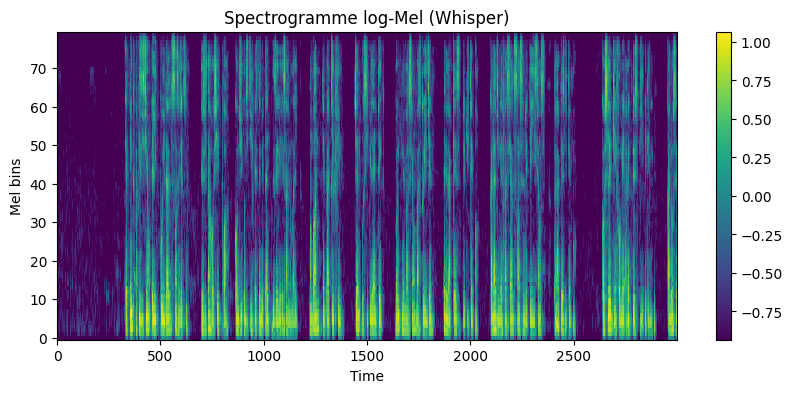

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np

features = ds_prepared['train'][90]["input_features"]
plt.figure(figsize=(10, 4))
plt.imshow(np.array(features), aspect="auto", origin="lower", interpolation="none")
plt.title("Spectrogramme log-Mel (Whisper)")
plt.xlabel("Time")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()

### Fine Tuning

In [16]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(
    "openai/whisper-tiny"
)

config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.75k [00:00<?, ?B/s]

In [17]:
model.generation_config.language = "fr"
model.generation_config.task = "transcribe"

#model.generation_config.forced_decoder_ids = [[1, None], [2, 50359]] #None

In [18]:
"""
# decoder_start_token_id
C’est un token spécial que le modèle doit recevoir au tout début de la séquence cible pendant l'entraînement.
Sans ce token de démarrage, le modèle ne saura pas où commencer la génération lors du décodage.

Il faut un ajout explicite du decoder_start_token_id au début de la séquence cible.
"""

"\n# decoder_start_token_id\nC’est un token spécial que le modèle doit recevoir au tout début de la séquence cible pendant l'entraînement.\nSans ce token de démarrage, le modèle ne saura pas où commencer la génération lors du décodage.\n\nIl faut un ajout explicite du decoder_start_token_id au début de la séquence cible.\n"

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int
    max_audio_len: int = 30 * 16000  # 30s at 16kHz
    max_label_len: int = 448 # le whisper-tiny a une longueur maximale de 448 tokens donc on peut augmenter la taille avec un plus gros modèle

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # -------- Audio --------
        # input_features = []
        # for feature in features:
        #     x = feature["input_features"]

        #     # trim or pad to 30 seconds (480_000 samples for Whisper)
        #     if x.shape[-1] > self.max_audio_len:
        #         x = x[..., :self.max_audio_len]
        #     elif x.shape[-1] < self.max_audio_len:
        #         pad_width = self.max_audio_len - x.shape[-1]
        #         x = torch.nn.functional.pad(x, (0, pad_width))
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # -------- Labels --------
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # Truncate labels to max_label_len
        labels = labels[:, :self.max_label_len]

        # Retirer le token de début s’il est déjà là, car Whisper l’ajoute pendant la génération
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # Ajouter manuellement le decoder_start_token_id
        decoder_start_tokens = torch.full((labels.size(0), 1), self.decoder_start_token_id, dtype=torch.long)
        labels = torch.cat([decoder_start_tokens, labels], dim=1)

        batch["labels"] = labels

        return batch


In [20]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

Evaluation

In [21]:
import evaluate

metric = evaluate.load("wer")

In [22]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [23]:
# Geler l'encodeur
for param in model.model.encoder.parameters():
       param.requires_grad = False

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-tiny-rad-fr",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    eval_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    warmup_steps=500,
    max_steps=5000,
    predict_with_generate=True,
    generation_max_length=225,
    gradient_checkpointing=True,
    learning_rate=3e-5,
    num_train_epochs=3,
    fp16=True,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,

)

from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=ds_prepared["train"],
    eval_dataset=ds_prepared["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=processor.feature_extractor,
)


trainer.train()


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
`use_cache = True` is incompatible with gradient checkpointing. Setting `use_cache = False`...


Step,Training Loss,Validation Loss,Wer
500,0.000700,0.217650,50.406504
1000,0.000200,0.217079,62.601626
1500,0.000100,0.218988,100.406504
2000,0.000100,0.221685,85.365854


You have passed task=transcribe, but also have set `forced_decoder_ids` to [[1, None], [2, 50359]] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 

In [ ]:
kwargs = {
    "language": "fr",
    "model_name": "Whisper Tiny Fr - Radiologie",
    "finetuned_from": "openai/whisper-tiny",
    "tasks": "automatic-speech-recognition",
}


In [ ]:
trainer.push_to_hub(**kwargs)